# Example 1-B: Pac-Man

This is a continuation of Example 1-A. We will compute $L^2$ inner products
and $H^1$ inner products of implicitly-defined functions on a punctured
Pac-Man domain.

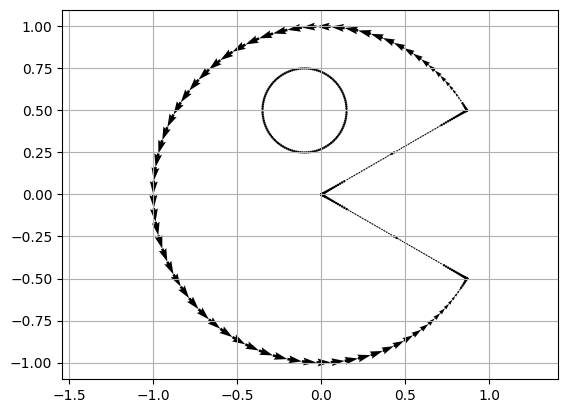

cell object
id: num_edges: 		4
num_holes: 		1
num_pts: 		512
contours: 		[[0, 1, 2], [3]]
hole_int_pts (x): 	[-0.1]
hole_int_pts (y): 	[0.5]



In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import puncturedfem as pf
import numpy as np

# define quadrature schemes
n = 64
q_trap = pf.quad(qtype='trap', n=n)
q_kress = pf.quad(qtype='kress', n=n)

# initialize list of edges as empty list
edge_list = []

# define some parameters (see below)
alpha = 1/2
beta = (np.pi / 3) * alpha

# derived parameters (see below)
ext_angle = beta / alpha
int_angle = 2 * np.pi - ext_angle
mouth_top = [np.cos(ext_angle / 2), np.sin(ext_angle / 2)]
mouth_bottom = [mouth_top[0], -mouth_top[1]]
int_angle_deg = int_angle * 180.0 / np.pi

# outer circular boundary
e = pf.edge(etype='circular_arc_deg', q=q_kress, theta0=int_angle_deg)
e.join_points(mouth_top, mouth_bottom)
edge_list.append(e)

# lower mouth
e = pf.edge(etype='line', q=q_kress)
e.join_points(mouth_bottom, [0, 0])
edge_list.append(e)

# upper mouth
e = pf.edge(etype='line', q=q_kress)
e.join_points([0, 0], mouth_top)
edge_list.append(e)

# eye
e = pf.edge(etype='circle', q=q_trap)
e.dialate(0.25)
e.translate([-0.1, 0.5])
e.reverse_orientation()
edge_list.append(e)

# check orientation
pf.plot_edges(edge_list, orientation=True)

# define mesh cell
K = pf.cell(edge_list=edge_list)
print(K)


## Function with a gradient singularity

Consider the function
\begin{align*}
	v(x) = r^\alpha \, \sin(\alpha \theta)
\end{align*}
where $x \mapsto (r, \theta)$ is given in polar coordinates,
and $\alpha = 1/2$ is a fixed parameter. 
Note that for $\alpha < 1$, 
the gradient $\nabla v$ has a singularity at the origin.
However, $v$ is harmonic everywhere else. 

In [2]:
# get Cartesian coordinates of points on boundary
x1, x2 = K.get_boundary_points()

# convert to polar
r = np.sqrt(x1 ** 2 + x2 ** 2)
th = np.arctan2(x2, x1) % (2 * np.pi)

# Dirichlet trace of v
v_trace = r ** alpha * np.sin(alpha * th)

# Laplacian of v (harmonic function)
v_lap = pf.polynomial()

# build local function
v = pf.locfun(v_trace, v_lap)

# compute quantities needed for integration
v.compute_all(K)

v.compute_harmonic_conjugate(K, debug=False)

Note that the normal derivative is unbounded near the origin.
Let's take a look at the weighted normal derivative.

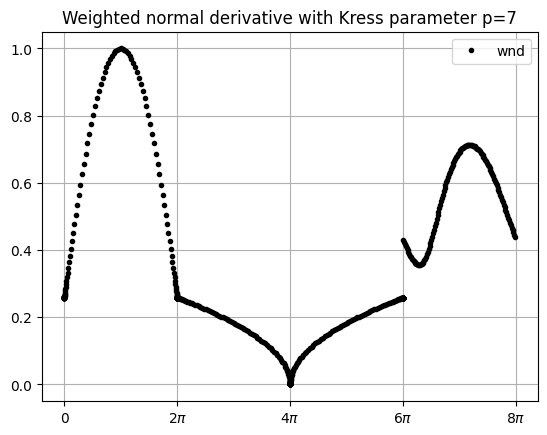

In [3]:
quad_list = [q_trap, q_kress,]
f_trace_list = [v.trace,]
fmt = ('k.',)
legend = ('wnd',)
title = f'Weighted normal derivative with Kress parameter p={q_kress.type[-1]}'
pf.plot_trace(f_trace_list, fmt, legend, title, K, quad_list)

### $H^1$ seminorm

Let's try computing the square $H^1$ seminorm of $v$, 
\begin{align*}
	\int_K |\nabla v|^2~dx
	&\approx 1.20953682240855912
	\pm 2.3929 \times 10^{-18}
\end{align*}
with an approximate value obtained with *Mathematica*.

In [4]:
h1_norm_sq_computed = v.compute_h1(v, K)
print('Computed square H^1 seminorm = ', h1_norm_sq_computed)

h1_norm_sq_exact = 1.20953682240855912
h1_norm_sq_error = abs(h1_norm_sq_computed - h1_norm_sq_exact)
print('Error in square H^1 seminorm = %.4e'%(h1_norm_sq_error))

Computed square H^1 seminorm =  1.209536869242796
Error in square H^1 seminorm = 4.6834e-08


### $L^2$ norm

Let's also try computing the $L^2$ norm
\begin{align*}
	\int_K v^2 ~dx
	&\approx 0.97793431492143971
	\pm 3.6199\times 10^{-19}
	~.
\end{align*}

In [5]:
l2_norm_sq_computed = v.compute_l2(v, K)
print('Computed square L^2 seminorm = ', l2_norm_sq_computed)

l2_norm_sq_exact = 0.977934314921439713
l2_norm_sq_error = abs(l2_norm_sq_computed - l2_norm_sq_exact)
print('Error in square L^2 seminorm = %.4e'%l2_norm_sq_error)

Computed square L^2 seminorm =  0.9779343127487921
Error in square L^2 seminorm = 2.1726e-09


### Convergence

Using Kress parameter $p=7$

|	n	|	H1 error	|	L2 error	|
|-------|---------------|---------------|
|	4	|	7.2078e-02	|	2.1955e-02	|
|	8	|	3.3022e-02	|	5.4798e-03	|
|	16	|	1.2495e-03	|	1.0159e-04	|
|	32	|	6.5683e-06	|	4.6050e-07	|
|	64	|	4.6834e-08	|	2.1726e-09	|

## Bonus: Interior values

asdf

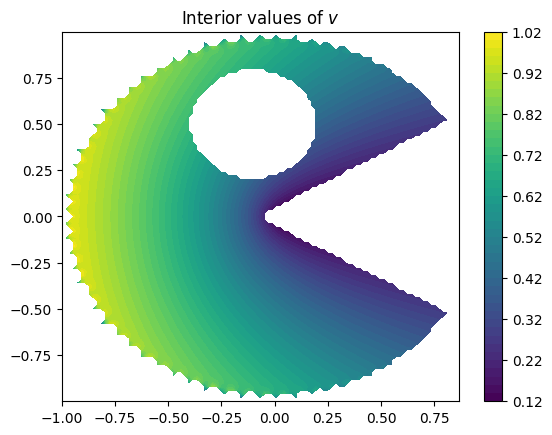

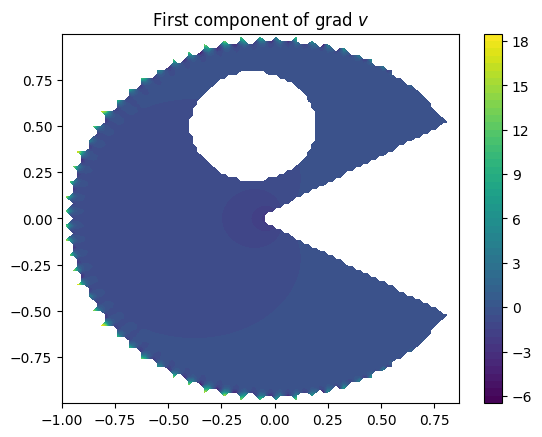

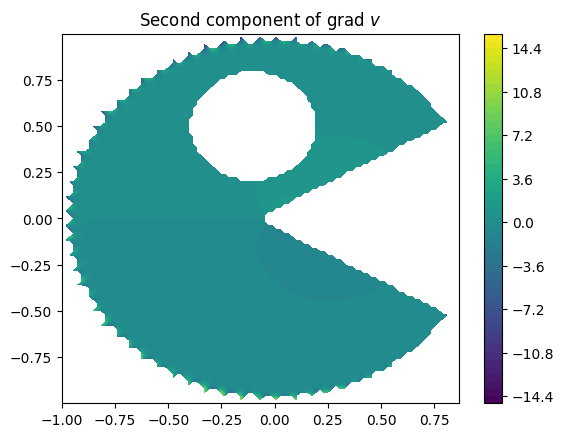

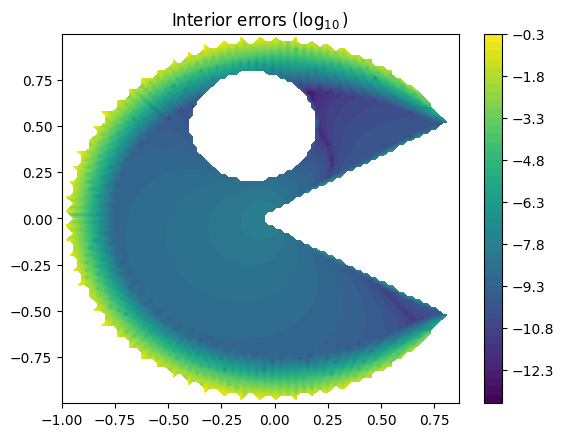

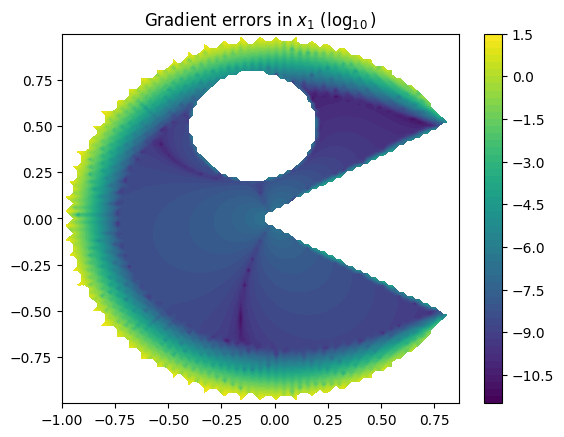

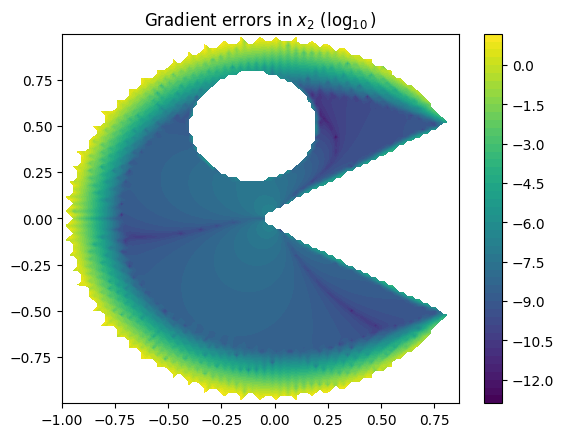

In [6]:
y1, y2, v_computed, v_x1_computed, v_x2_computed = \
    pf.interior_values(v, K)

import matplotlib.pyplot as plt

plt.figure()
plt.contourf(y1, y2, v_computed, levels=50)
plt.colorbar()
plt.title('Interior values of $v$')

plt.figure()
plt.contourf(y1, y2, v_x1_computed, levels=50)
plt.colorbar()
plt.title('First component of grad $v$')

plt.figure()
plt.contourf(y1, y2, v_x2_computed, levels=50)
plt.colorbar()
plt.title('Second component of grad $v$')

# convert to polar
r = np.sqrt(y1 ** 2 + y2 ** 2)
th = np.arctan2(y2, y1) % (2 * np.pi)

# exact values
cos_th = np.cos(th)
sin_th = np.sin(th)
cos_ath = np.cos(alpha * th)
sin_ath = np.sin(alpha * th)

v_exact = r ** alpha * sin_ath
v_x1_exact = alpha * r ** (alpha - 1) * (cos_th * sin_ath - sin_th * cos_ath)
v_x2_exact = alpha * r ** (alpha - 1) * (sin_th * sin_ath + cos_th * cos_ath)

# interior value errors
v_error = np.log10(np.abs(v_computed - v_exact))
plt.figure()
plt.contourf(y1, y2, v_error, levels=50)
plt.colorbar()
plt.title('Interior errors ($\log_{10}$)')

# first component of gradient errors
v_x1_error = np.log10(np.abs(v_x1_computed - v_x1_exact))
plt.figure()
plt.contourf(y1, y2, v_x1_error, levels=50)
plt.colorbar()
plt.title('Gradient errors in $x_1$ ($\log_{10}$)')

# second component of gradient errors
v_x2_error = np.log10(np.abs(v_x2_computed - v_x2_exact))
plt.figure()
plt.contourf(y1, y2, v_x2_error, levels=50)
plt.colorbar()
plt.title('Gradient errors in $x_2$ ($\log_{10}$)')

plt.show()